In [28]:
import pycaret
pycaret.__version__

'3.1.0'

In [29]:
import pandas as pd
import datetime
import warnings

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('float_format', '{:f}'.format)

In [30]:
data_train = pd.read_parquet('../data/processed/train.gzip')
data_test = pd.read_parquet('../data/processed/test.gzip')
data_test_id = data_test[['ID']]

for col in ['CO_TIPO_SEXO', 'ANIO_BANCARIZACION', 'MES_BANCARIZACION']:
    data_train[col] = data_train[col].astype('category')
    data_test[col] = data_test[col].astype('category')

TARGET_VAR = 'TARGET'

In [31]:
data_train.dtypes

ID                                           object
TARGET                                        int64
CO_TIPO_SEXO                               category
EDAD                                        float64
ANIO_BANCARIZACION                         category
MES_BANCARIZACION                          category
CANT_EMP_NEG_max                              int64
CANT_EMP_NEG_last                             int64
CANT_EMP_CONS_max                             int64
CANT_EMP_CONS_last                            int64
CANT_EMP_HIPOT_max                            int64
CANT_EMP_HIPOT_last                           int64
SALDO_EMP_TOTAL_mean                        float64
SALDO_EMP_TOTAL_last                        float64
SALDO_EMP_TOTAL_max                         float64
SALDO_EMP_TOTAL_min                         float64
VAR_SALDO_EMP_TOTAL_1_mean                  float64
VAR_SALDO_EMP_TOTAL_1_median                float64
VAR_SALDO_EMP_TOTAL_MA3_mean                float64
VAR_SALDO_EM

In [32]:
# get only numeric columns
data = data_train.select_dtypes(include=['int64', 'float64'])# pd.concat([data_train.select_dtypes(include=['int64', 'float64']), data_train['ID']], axis=1)
data = data.drop(columns=['EDAD'])
data = data[[col for col in data.columns if all([sub not in col for sub in ['PROXY_']])]]

data_test = data_test.select_dtypes(include=['int64', 'float64'])
data_test = data_test.drop(columns=['EDAD'])

In [33]:
# perform min max normalization in all columns
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
data_scaled = data.copy()

data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
data_scaled[TARGET_VAR] = data_train[TARGET_VAR]

In [34]:
# from imblearn.under_sampling import RepeatedEditedNearestNeighbours

# renn = RepeatedEditedNearestNeighbours(kind_sel='all')
# X, y = renn.fit_resample(data_scaled.drop(columns=[TARGET_VAR]), data_scaled[TARGET_VAR])

In [35]:
# data_scaled = pd.concat([X, y], axis=1)

data_scaled[TARGET_VAR].value_counts(normalize=True)

0   0.849994
1   0.150006
Name: TARGET, dtype: float64

In [36]:
# variable selection with PCA
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95)
# data_pca = pca.fit_transform(data_scaled.drop(TARGET_VAR, axis=1))
# data_pca = pd.DataFrame(data_pca)
# data_pca[TARGET_VAR] = data_scaled[TARGET_VAR]
# data_pca.head(36)

In [37]:
data_scaled[TARGET_VAR].value_counts(normalize=True)

0   0.849994
1   0.150006
Name: TARGET, dtype: float64

In [38]:
from pycaret.classification import *
s = setup(data_scaled, target=TARGET_VAR, session_id=123, use_gpu=True)


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that 

,Description,Value
0,Session id,123
1,Target,TARGET
2,Target type,Binary
3,Original data shape,"(91183, 43)"
4,Transformed data shape,"(91183, 43)"
5,Transformed train set shape,"(63828, 43)"
6,Transformed test set shape,"(27355, 43)"
7,Numeric features,42
8,Preprocess,True
9,Imputation type,simple


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that 

In [39]:
# from pycaret.classification import ClassificationExperiment
# exp = ClassificationExperiment()
# exp.setup(data_pca, target=TARGET_VAR, session_id=123, use_gpu=True)
# exp.compare_models()

In [40]:
# add F1 macro to metrics
from sklearn.metrics import f1_score, make_scorer

try:
    def f1_macro(y_true, y_pred):
        return f1_score(y_true, y_pred, average='macro')

    add_metric('f1_macro', 'F1 Macro', f1_macro, greater_is_better=True)
except:
    pass

In [41]:
get_metrics()

,Name,Display Name,Score Function,Scorer,Target,Args,Greater is Better,Multiclass,Custom
ID,,,,,,,,,
acc,Accuracy,Accuracy,<function accuracy_score at 0x7fd166de9a20>,accuracy,pred,{},True,True,False
auc,AUC,AUC,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(roc_auc_score, needs_proba=True, e...",pred_proba,"{'average': 'weighted', 'multi_class': 'ovr'}",True,True,False
recall,Recall,Recall,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(recall_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
precision,Precision,Prec.,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(precision_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
f1,F1,F1,<pycaret.internal.metrics.BinaryMulticlassScor...,"make_scorer(f1_score, average=weighted)",pred,{'average': 'weighted'},True,True,False
kappa,Kappa,Kappa,<function cohen_kappa_score at 0x7fd166de9b40>,make_scorer(cohen_kappa_score),pred,{},True,True,False
mcc,MCC,MCC,<function matthews_corrcoef at 0x7fd166de9c60>,make_scorer(matthews_corrcoef),pred,{},True,True,False
f1_macro,F1 Macro,F1 Macro,<pycaret.internal.metrics.EncodedDecodedLabels...,make_scorer(f1_macro),pred,{},True,True,True


In [42]:
all_models = models()
all_models

# for model_id, model_name in all_models.items():
#     print(f"Model ID: {model_id}, Model Name: {model_name}")

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce GTX 1650 Ti, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that 

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [43]:
best = compare_models(sort='F1 Macro', exclude=['knn', 'svm', 'rbfsvm', 'dummy', 'lda', 'lr', 'nb', 'ridge', 'qda', 'gpc', 'et'])

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,13:00:03
Status,. . . . . . . . . . . . . . . . . .,Loading Estimator
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F1 Macro,TT (Sec)
xgboost,Extreme Gradient Boosting,0.8599,0.7868,0.2198,0.5880,0.3198,0.2594,0.2989,0.6208,0.5060
catboost,CatBoost Classifier,0.8628,0.7979,0.2031,0.6326,0.3074,0.2530,0.3040,0.6156,3.6350
lightgbm,Light Gradient Boosting Machine,0.8620,0.7972,0.2022,0.6235,0.3052,0.2502,0.2998,0.6143,0.7540
rf,Random Forest Classifier,0.8587,0.7716,0.1977,0.5860,0.2956,0.2380,0.2819,0.6085,2.9150
ada,Ada Boost Classifier,0.8585,0.7753,0.1774,0.5949,0.2732,0.2195,0.2696,0.5974,5.4280
gbc,Gradient Boosting Classifier,0.8611,0.7887,0.1718,0.6367,0.2705,0.2209,0.2799,0.5969,28.2840
dt,Decision Tree Classifier,0.7893,0.5877,0.3241,0.3080,0.3157,0.1913,0.1914,0.5956,2.0500


In [44]:
# tuned_model = tune_model(best, optimize='F1 Macro')

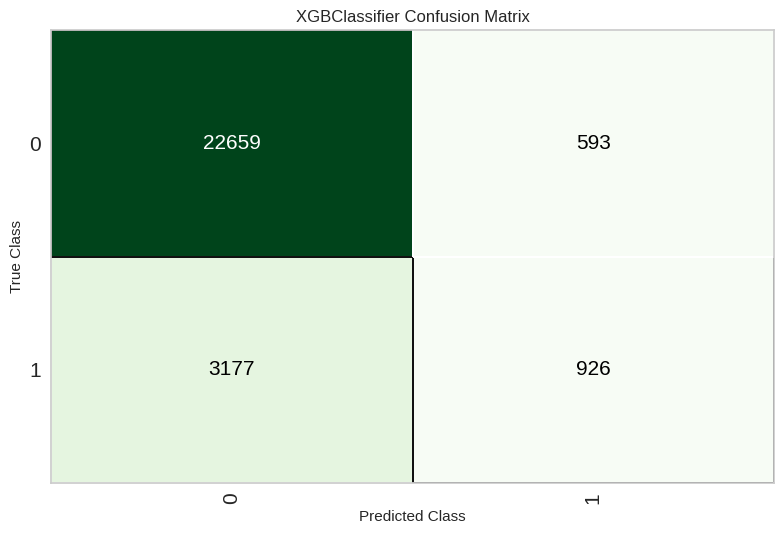

In [45]:
plot_model(best, plot='confusion_matrix')

In [46]:
# plot_model(best, plot='learning')

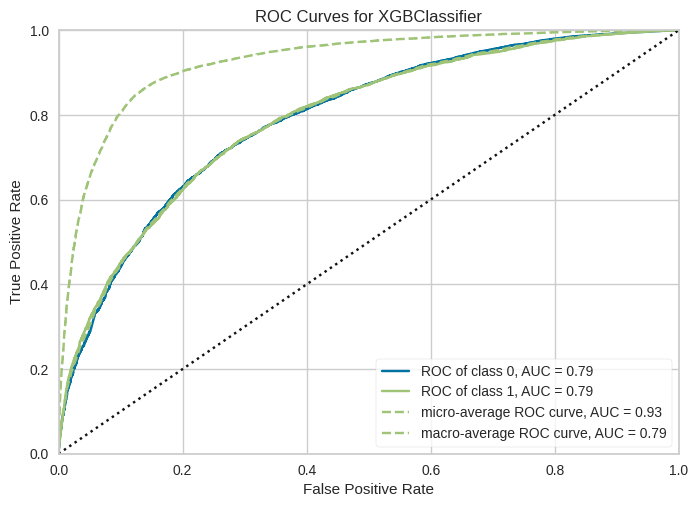

In [47]:
plot_model(best, plot='auc')

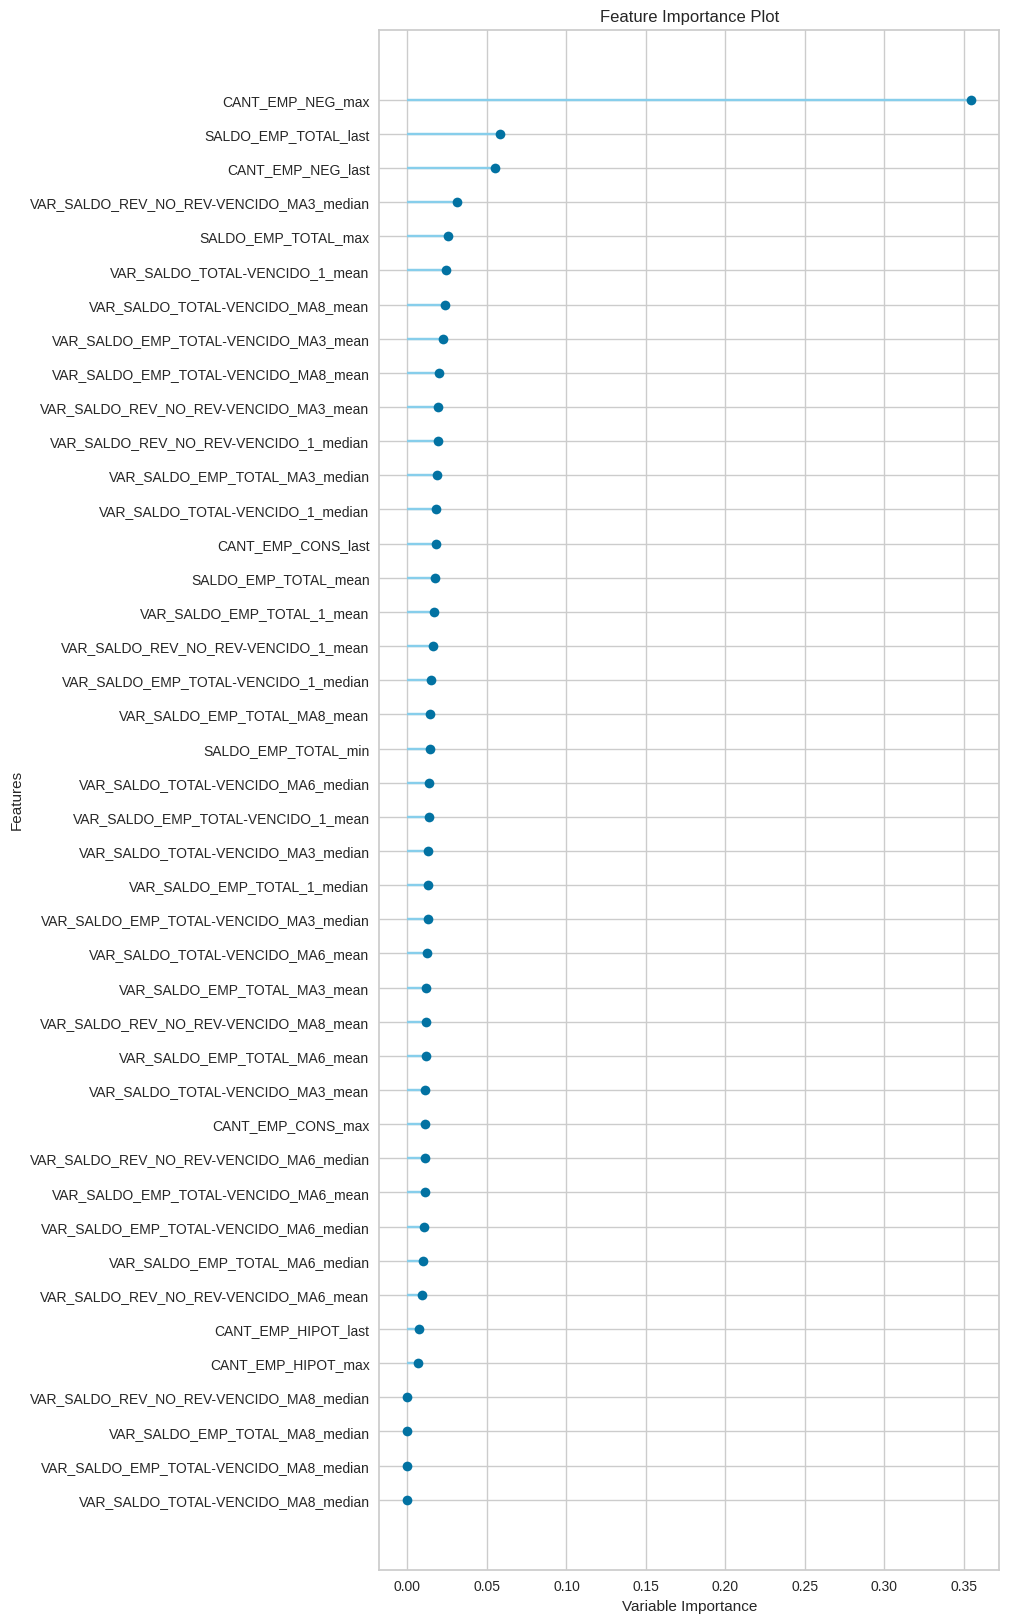

In [48]:
try:
    plot_model(best, plot='feature_all')
except:
    pass

In [49]:
holdout_pred = predict_model(best)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F1 Macro
0,Extreme Gradient Boosting,0.8622,0.7929,0.2257,0.6096,0.3294,0.2703,0.3121,0.6263


In [50]:
predictions_train = predict_model(best, data=data_scaled)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,F1 Macro
0,Extreme Gradient Boosting,0.8794,0.8608,0.2998,0.7429,0.4272,0.3731,0.4214,0.6799


In [51]:
# confusion matrix and classification report
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(predictions_train[TARGET_VAR], predictions_train['prediction_label'], normalize='true')
cm = pd.DataFrame(cm, columns=['0', '1'])
cm.index = ['0', '1']
display(cm)

print(classification_report(predictions_train[TARGET_VAR], predictions_train['prediction_label']))

,0,1
0,0.981692,0.018308
1,0.700249,0.299751


              precision    recall  f1-score   support

           0       0.89      0.98      0.93     77505
           1       0.74      0.30      0.43     13678

    accuracy                           0.88     91183
   macro avg       0.82      0.64      0.68     91183
weighted avg       0.87      0.88      0.86     91183



In [52]:
predictions = predict_model(best, data=data_test.drop(columns=[TARGET_VAR]))

In [53]:
predictions['prediction_label'].value_counts(normalize=True)

0   0.559937
1   0.440063
Name: prediction_label, dtype: float64

In [ ]:
now = datetime.datetime.now().strftime('%Y-%m-%d_%H:%M:%S')

In [55]:
pd.concat([data_test_id, predictions[['prediction_label']]], axis=1).rename(columns={'prediction_label': TARGET_VAR}).to_csv(f'../data/results/submission_{now}.csv', index=False)  # , 'prediction_score'